# Brecha de género

En este documento queremos analizar la diferencia de sueldos entre hombres y mujeres, cuánto de ella podemos explicar con las respuestas de la encuesta, por ejemplo considerando si un grupo tiene mayor experiencia laboral que otro. También usar encuestas pasadas para analizar la tendencia.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
df = pd.read_csv('2020.1 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv', skiprows=9)
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10_000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]
df.head()

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?"
0,Hombre,40,Catamarca,15.0,0.0,0.0,0,Universitario,Completado,Licenciatura en Sistemas de Información,...,NaN,NaN,NaN,201-500,Otras industrias,6,6,4.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN
1,Mujer,35,Catamarca,15.0,10.0,3.0,5,Posgrado,Completado,Licenciatura en Sistemas de Información,...,NaN,No,NaN,11-50,Servicios / Consultoría de Software / Digital,5,8,2.0,Abono de celular y/o Internet,NaN
2,Hombre,39,Chaco,10.0,5.0,5.0,6,Universitario,Incompleto,Ingeniería en Sistemas de Información,...,NaN,NaN,Ekoparty,11-50,Servicios / Consultoría de Software / Digital,10,10,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",NaN
3,Hombre,42,Chaco,18.0,3.0,3.0,0,Universitario,Completado,Licenciatura en Análisis de Sistemas,...,NaN,No,NaN,11-50,Producto basado en Software,5,3,-1.0,"Horarios flexibles, Sueldo dolarizado, WFH (Tr...",NaN
4,Hombre,29,Chaco,4.0,0.0,0.0,1,Universitario,Completado,Ingeniería Electrónica,...,NaN,NaN,"Pynea, Autodefensa digital",201-500,Otras industrias,8,9,5.0,"Abono de celular y/o Internet, Comidas pagas /...",NaN


In [13]:
df['Me identifico'].value_counts()

Hombre    4922
Mujer      820
Otros       24
Name: Me identifico, dtype: int64

Lamentablemente hay muy pocas respuestas que no son hombre o mujer y no alcanzan los datos para sacar conclusiones, así que descartaré esos datos desde acá.

In [14]:
df = df[df['Me identifico'] != 'Otros']

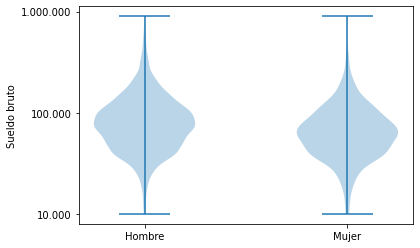

In [39]:
plt.ylabel('Sueldo bruto')
plt.xticks([1, 2], ['Hombre', 'Mujer'])
plt.yticks([4, 5, 6], ['10.000', '100.000', '1.000.000'])
plt.violinplot([
    np.log10(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].values),
    np.log10(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].values),
]);


/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-2020.1-TStUcAYq/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


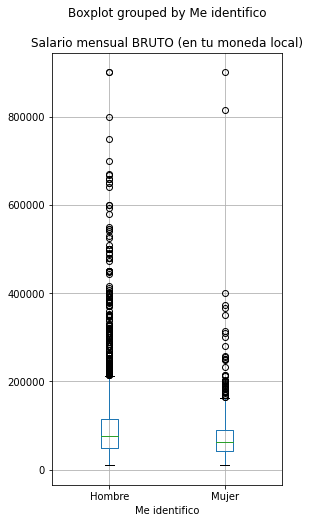

In [45]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Me identifico', figsize=(4, 8));

In [4]:
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
df['region'] = df['Dónde estás trabajando'].apply(lambda x: regions_map[x])

In [72]:
df[df['Me identifico'] == 'Mujer']['region'].value_counts()

AMBA         675
Pampa        110
Cuyo          14
NEA           12
NOA            5
Patagonia      4
Name: region, dtype: int64

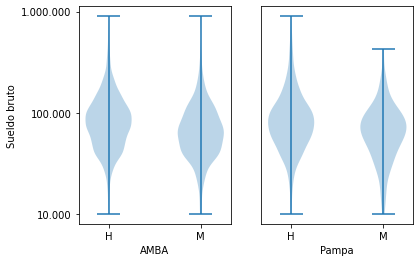

In [77]:
regions = ['AMBA', 'Pampa']
f, axs = plt.subplots(1, len(regions),figsize=(6, 4))
for i, region in enumerate(regions):
    ax = plt.subplot(1, len(regions), i+1)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([4, 5, 6])
    else:
        ax.set_yticks([])
    ax.set_xlabel(region)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        np.log10(df[(df['Me identifico'] == 'Hombre') & (df['region'] == region)]['Salario mensual BRUTO (en tu moneda local)'].values),
        np.log10(df[(df['Me identifico'] == 'Mujer') & (df['region'] == region)]['Salario mensual BRUTO (en tu moneda local)'].values),
    ]);


In [87]:
degrees = df[df['Me identifico'] == 'Mujer']['Carrera'].value_counts()
degrees = degrees[degrees > 25].keys().to_list()

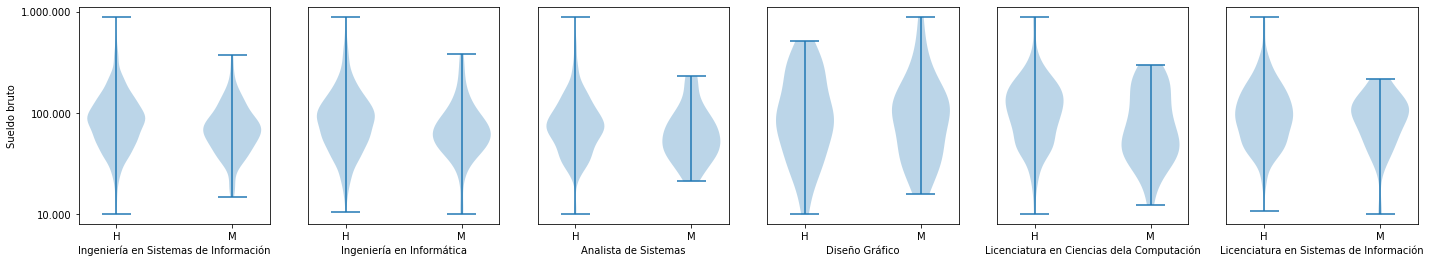

In [93]:
f, axs = plt.subplots(1, len(degrees),figsize=(24, 4))
for i, degree in enumerate(degrees):
    ax = plt.subplot(1, len(degrees), i+1)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([4, 5, 6])
    else:
        ax.set_yticks([])
    ax.set_xlabel(degree)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        np.log10(df[(df['Me identifico'] == 'Hombre') & (df['Carrera'] == degree)]['Salario mensual BRUTO (en tu moneda local)'].values),
        np.log10(df[(df['Me identifico'] == 'Mujer') & (df['Carrera'] == degree)]['Salario mensual BRUTO (en tu moneda local)'].values),
    ]);


In [9]:
def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'provincia={regions_map[row["Dónde estás trabajando"]]}'
    ]

counts = {}
for i in range(df.shape[0]):
    for word in row_to_words(df.iloc[i]):
        counts[word] = counts.get(word, 0) + 1

valid_words = [word for word, c in counts.items() if c > 1]


def encode_row(row):
    ws = row_to_words(row)
    return pd.Series([w in ws for w in valid_words] + [
        row['¿Gente a cargo?'],
        row['Años de experiencia'],
        row['Tengo'],
    ])
df_encoded = df.apply(encode_row, axis=1).astype(float)
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.65, 'learning_rate': 0.05, 'max_depth': 23, 'min_child_weight': 8.0, 'n_estimators': 245, 'subsample': 0.8718795402022754}
cross_val_score(xgb.XGBRegressor(**best), df_encoded, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.6230504522865787